In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from tqdm import tqdm
sys.path.append('../src/scripts')
from multizone_stars import MultizoneStars
from utils import get_bin_centers
import vice

In [5]:
output_name = 'gaussian/insideout/powerlaw_slope11/diskmodel'
mzs = MultizoneStars.from_output(output_name)

In [57]:
stars = mzs.filter({
    # 'galr_final': (6, 12), 
    # 'zfinal': (0, 1), 
    'mstar': (1, None), 
    # '[fe/h]': (-1, None),
    # 'age': (None, 13),
}).stars.copy()
stars['bin'] = pd.cut(stars['age'], bins=np.arange(14), include_lowest=True)
grouped = stars.groupby('bin')
feh_range = grouped.quantile(0.95)['[fe/h]'] - grouped.quantile(0.05)['[fe/h]']

In [58]:
# [Fe/H] gradient conversion
grad_slope = -0.08
grad_intercept = -0.07
# normalized [Fe/H] range
feh_range_norm = feh_range - feh_range.min()
feh_range_norm /= feh_range_norm.max()
feh_birth_grad = grad_slope * feh_range_norm + grad_intercept

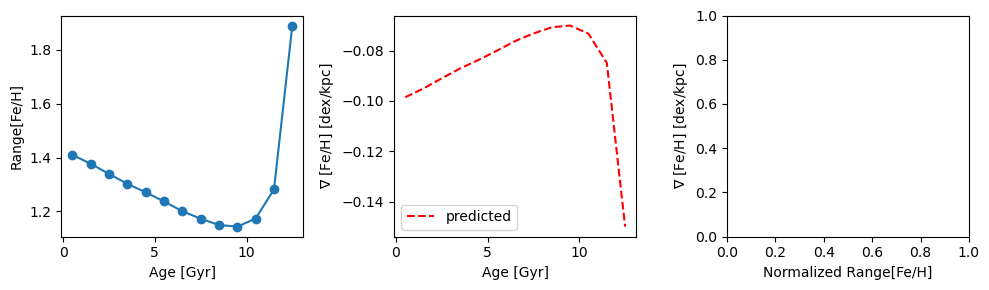

In [66]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3), tight_layout=True)

age_array = np.arange(0.5, 13, 1)

axs[0].plot(age_array, feh_range, 'o-')
axs[0].set_xlabel('Age [Gyr]')
axs[0].set_ylabel('Range[Fe/H]')

axs[1].plot(age_array, feh_birth_grad, 'r--', label='predicted')
axs[1].set_xlabel('Age [Gyr]')
axs[1].set_ylabel(r'$\nabla$ [Fe/H] [dex/kpc]')
axs[1].legend()

axs[2].set_xlabel('Normalized Range[Fe/H]')
axs[2].set_ylabel(r'$\nabla$ [Fe/H] [dex/kpc]')
plt.show()